### Pytorch Forecasting 테스트

In [2]:
# Pytorch 사용해보기
# %pip install pytorch-forecasting

In [3]:
# ToDo
# 1. Create a training dataset -> TimeSeriesDataSet
# 2. Create a validation dataset -> from_dataset()
# 3. Instantiate a trainer -> .from_dataset()
# 4. Create a lighting.Trainer() object
# 5. Find Optimal Learning Rate -> .tuner.lr_find()
# 6. Train the model -> .fit()
# 7. Make predictions -> .predict()

In [4]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

warnings.filterwarnings("ignore")

c:\Users\wjs31\anaconda3\envs\Torch_NLP\lib\site-packages\pytorch_forecasting\models\base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


### 마지막 import가 안되지만 일단 패스

In [5]:
# Data Preparation
data = pd.read_csv('../DATA/data_with_btc_scaled.csv')
data.head(), data.info(), data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1739 entries, 0 to 1738
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1739 non-null   object 
 1   btc     1739 non-null   float64
 2   Gold    1739 non-null   float64
 3   Dollar  1739 non-null   float64
 4   SnP     1739 non-null   float64
dtypes: float64(4), object(1)
memory usage: 68.1+ KB


(         date       btc      Gold    Dollar       SnP
 0  2017-08-17  0.015684  0.101088  0.197100  0.063838
 1  2017-08-18  0.013155  0.100342  0.189655  0.062380
 2  2017-08-21  0.011834  0.105098  0.176332  0.063308
 3  2017-08-22  0.012177  0.099782  0.194357  0.071296
 4  2017-08-23  0.013236  0.103233  0.178683  0.068479,
 None,
                btc         Gold       Dollar          SnP
 count  1739.000000  1739.000000  1739.000000  1739.000000
 mean      0.271838     0.447349     0.360380     0.447282
 std       0.242666     0.257854     0.208724     0.250323
 min       0.000000     0.000000     0.000000     0.000000
 25%       0.070461     0.142446     0.190635     0.203281
 50%       0.195223     0.535654     0.329937     0.472324
 75%       0.439977     0.653528     0.535005     0.665926
 max       1.000000     1.000000     1.000000     1.000000)

In [6]:
# # date 컬럼을 datetime으로 변환
# data['time_idx'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
# data = data[['time_idx', 'btc', 'Gold', 'Dollar', 'SnP']]
# data.head(), data.info(), data.describe()


data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

In [7]:
# add time index : datetime to int
data["time_idx"] = (data["date"].dt.year * 12 + data["date"].dt.month) * 30 + data["date"].dt.day
data["time_idx"] -= data["time_idx"].min()
# 여기서 day 반영
# data["time_idx"] += data["date"].dt.day / 30.5

# add additional features
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
# data["log_volume"] = np.log(data.volume + 1e-8)
# data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
# data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

In [8]:
# time_idx 중복 검사
data["time_idx"].value_counts().sort_index()    # 중복 없음

time_idx
0       1
1       1
4       1
5       1
6       1
       ..
2379    1
2380    1
2381    1
2382    1
2384    1
Name: count, Length: 1709, dtype: int64

In [9]:
# group_ids를 추가 : 모든 데이터가 같은 그룹에 속하므로 모든 값이 0
data['group'] = 0

# month 컬럼 추가 : 월별로 데이터를 나누기 위함
# data['month'] = data['date'].dt.month
data.head()

,date,btc,Gold,Dollar,SnP,time_idx,month,group
0,2017-08-17,0.015684,0.101088,0.197100,0.063838,0,8,0
1,2017-08-18,0.013155,0.100342,0.189655,0.062380,1,8,0
2,2017-08-21,0.011834,0.105098,0.176332,0.063308,4,8,0
3,2017-08-22,0.012177,0.099782,0.194357,0.071296,5,8,0
4,2017-08-23,0.013236,0.103233,0.178683,0.068479,6,8,0


In [10]:
# time_idx -> int
data['time_idx'] = data['time_idx'].astype(int)
data.head()

,date,btc,Gold,Dollar,SnP,time_idx,month,group
0,2017-08-17,0.015684,0.101088,0.197100,0.063838,0,8,0
1,2017-08-18,0.013155,0.100342,0.189655,0.062380,1,8,0
2,2017-08-21,0.011834,0.105098,0.176332,0.063308,4,8,0
3,2017-08-22,0.012177,0.099782,0.194357,0.071296,5,8,0
4,2017-08-23,0.013236,0.103233,0.178683,0.068479,6,8,0


In [11]:
max_encoder_length = 300 
max_prediction_length = 30 
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="btc",
    group_ids=["group"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    # static_categoricals=["agency", "sku"],
    # static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["month"],
    # variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["Gold", "Dollar", "SnP"],
    # target_normalizer=GroupNormalizer(
        # groups=["agency", "sku"], transformation="softplus"
    # ),  # use softplus and normalize by group
    allow_missing_timesteps=True,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [12]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.0804)

In [13]:
# # configure network and trainer
# pl.seed_everything(42)
# trainer = pl.Trainer(
#     accelerator="cpu",
#     # clipping gradients is a hyperparameter and important to prevent divergance
#     # of the gradient for recurrent neural networks
#     gradient_clip_val=0.1,
# )

# tft = TemporalFusionTransformer.from_dataset(
#     training,
#     # not meaningful for finding the learning rate but otherwise very important
#     learning_rate=0.03,
#     hidden_size=8,  # most important hyperparameter apart from learning rate
#     # number of attention heads. Set to up to 4 for large datasets
#     attention_head_size=1,
#     dropout=0.1,  # between 0.1 and 0.3 are good values
#     hidden_continuous_size=8,  # set to <= hidden_size
#     loss=QuantileLoss(),
#     optimizer="Ranger"
#     # reduce learning rate if no improvement in validation loss after x epochs
#     # reduce_on_plateau_patience=1000,
# )
# print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")


In [14]:
# from lightning.pytorch.tuner import Tuner

# res = Tuner(trainer).lr_find(
#     tft,
#     train_dataloaders = train_dataloader,
#     val_dataloaders = val_dataloader,
#     max_lr = 10.0,
#     min_lr = 1e-6,
# )

# print(f"suggested learning rate : {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)
# fig.show()

In [15]:
# %pip install tensorboard
# %pip install tensorboardX

In [16]:
# # configure network and trainer
# early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
# lr_logger = LearningRateMonitor()  # log the learning rate
# logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

# trainer = pl.Trainer(
#     max_epochs=50,
#     accelerator="cpu",
#     enable_model_summary=True,
#     gradient_clip_val=0.1,
#     limit_train_batches=50,  # coment in for training, running valiation every 30 batches
#     # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
#     callbacks=[lr_logger, early_stop_callback],
#     logger=logger,
# )

# tft = TemporalFusionTransformer.from_dataset(
#     training,
#     learning_rate=0.03,
#     hidden_size=16,
#     attention_head_size=2,
#     dropout=0.1,
#     hidden_continuous_size=8,
#     loss=QuantileLoss(),
#     log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
#     optimizer="Ranger",
#     reduce_on_plateau_patience=4,
# )
# print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

In [17]:
# # fit network
# trainer.fit(
#     tft,
#     train_dataloaders=train_dataloader,
#     val_dataloaders=val_dataloader,
# )

In [18]:
# import pickle

# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# # create study
# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path="optuna_test",
#     n_trials=200,
#     max_epochs=50,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 128),
#     hidden_continuous_size_range=(8, 128),
#     attention_head_size_range=(1, 4),
#     learning_rate_range=(0.001, 0.1),
#     dropout_range=(0.1, 0.3),
#     trainer_kwargs=dict(limit_train_batches=30),
#     reduce_on_plateau_patience=4,
#     use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
# )

# # save study results - also we can resume tuning at a later point in time
# with open("test_study.pkl", "wb") as fout:
#     pickle.dump(study, fout)

# # show best hyperparameters
# print(study.best_trial.params)

In [19]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
# best_model_path = trainer.checkpoint_callback.best_model_path
best_model_path = 'lightning_logs\\lightning_logs\\version_0\\checkpoints\\epoch=29-step=510.ckpt'
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [20]:
# best_model_path

In [21]:
# calcualte mean absolute error on validation set
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.1207)

In [22]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


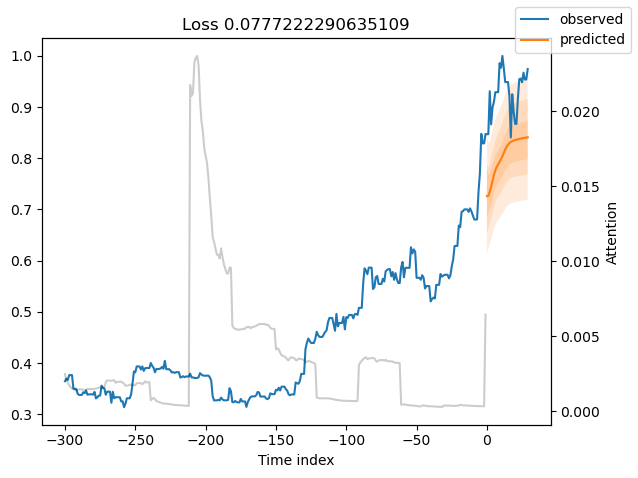

In [23]:
for idx in range(1):  # plot 10 examples
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


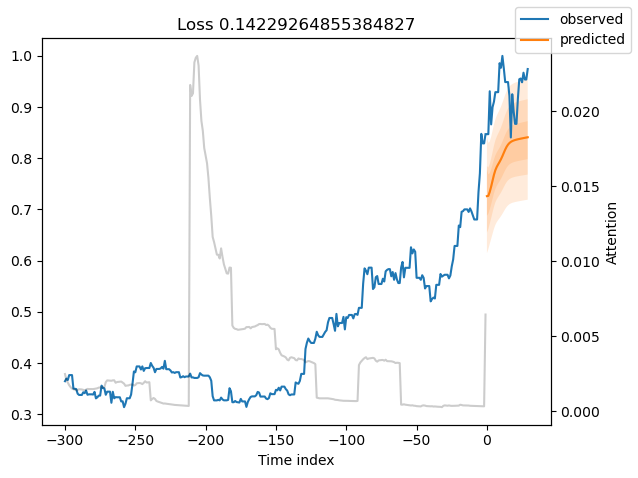

In [24]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader, return_y=True)
mean_losses = SMAPE(reduction="none")(predictions.output, predictions.y).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(1):  # plot 10 examples
    best_tft.plot_prediction(
        raw_predictions.x,
        raw_predictions.output,
        idx=indices[idx],
        add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles),
    )

### 미래 데이터 예측하기

In [ ]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

In [ ]:
new_raw_predictions = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

for idx in range(1):  # plot 10 examples
    best_tft.plot_prediction(new_raw_predictions.x, new_raw_predictions.output, idx=idx, show_future_observed=False)

### Interpret Model

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x275 with 1 Axes>,
 'encoder_variables': <Figure size 700x350 with 1 Axes>,
 'decoder_variables': <Figure size 700x275 with 1 Axes>}

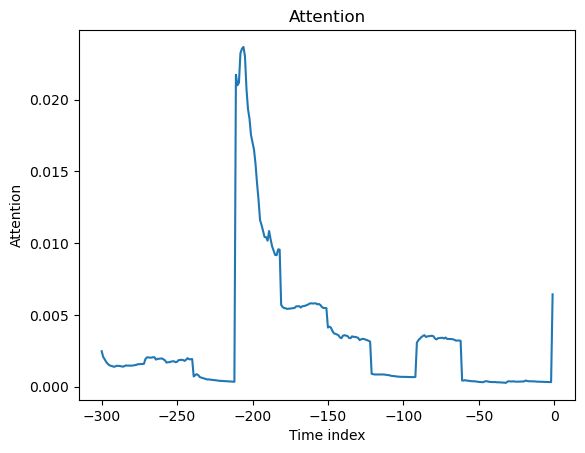

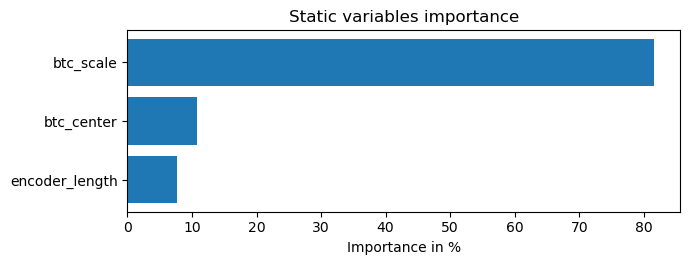

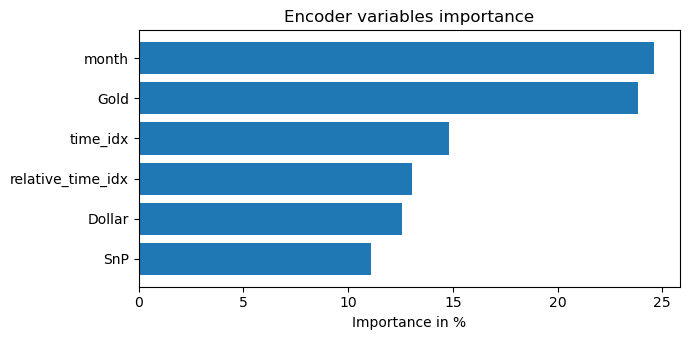

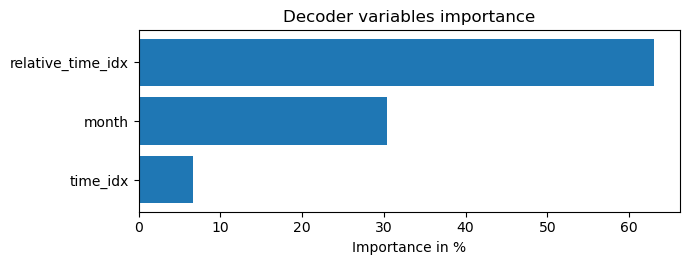

In [25]:
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)